<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Reduced-RFM" data-toc-modified-id="Reduced-RFM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reduced RFM</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Groups" data-toc-modified-id="Groups-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Groups</a></span></li><li><span><a href="#FM" data-toc-modified-id="FM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>FM</a></span></li><li><span><a href="#UMAP,-age-bins,-group-sum" data-toc-modified-id="UMAP,-age-bins,-group-sum-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>UMAP, age bins, group sum</a></span></li><li><span><a href="#UMAP,-k-means-group-sum" data-toc-modified-id="UMAP,-k-means-group-sum-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>UMAP, k means group sum</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

## Data

In [2]:
df = pd.read_csv('../data/transactions_train.csv')

In [3]:
df = df.sort_values(['client_id', 'trans_date'])

In [4]:
bins = pd.read_csv('../data/train_target.csv')

In [5]:
df = pd.merge(df, bins, on='client_id')

In [6]:
print('before downsampling:\n', df.dtypes)
df['client_id'] = pd.to_numeric(df['client_id'], downcast='unsigned')
df['trans_date'] = pd.to_numeric(df['trans_date'], downcast='unsigned')
df['small_group'] = pd.to_numeric(df['small_group'], downcast='signed')
df['amount_rur'] = pd.to_numeric(df['amount_rur'], downcast='float')

print('after downsampling:\n',df.dtypes)

before downsampling:
 client_id        int64
trans_date       int64
small_group      int64
amount_rur     float64
bins             int64
dtype: object
after downsampling:
 client_id       uint16
trans_date      uint16
small_group      int16
amount_rur     float32
bins             int64
dtype: object


In [7]:
groups = pd.read_csv('../data/small_group_description.csv')

In [8]:
code2group = {}
for _, r in groups.iterrows():
    code2group[r['small_group_code']] = r['small_group']

In [9]:
df['weekday'] = df['trans_date'] % 7

## Reduced RFM

https://www.mdpi.com/1911-8074/14/2/50

recency (**maybe**) - maybe not

frequency - avg number of days between transactions, % of transactions in group, **maybe** number of transactions weekday

monetary - avg amount min max sum in group, avg amount

frequency

In [43]:
df['trans_date_diff'] = df['trans_date'].shift(-1) - df['trans_date']

In [44]:
df[df['trans_date_diff'] < 0] = np.nan

In [45]:
tmp = df.groupby(['client_id'])['trans_date_diff'].agg(['mean'])

In [46]:
tmp.columns = ['mean_days']

In [47]:
client_df = tmp.copy()

In [48]:
tmp = df.groupby(['client_id', 'small_group'])['amount_rur'].count().reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values='amount_rur')
tmp = tmp.fillna(0)

In [49]:
tmp = tmp.div(tmp.apply(sum, axis=1), axis='index')

In [50]:
tmp.columns = [f'group{int(c)}_cnt' for c in tmp.columns]

In [51]:
client_df = client_df.join(tmp)

monetary

In [52]:
tmp = df.groupby(['client_id', 'small_group'])['amount_rur'].agg(['mean', 'max', 'min', 'sum']).reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values=['mean', 'max', 'min', 'sum'])
#tmp = tmp.fillna(0)

In [53]:
tmp.columns = [f'group{int(c2)}_{c1}' for c1, c2 in tmp.columns]

In [54]:
client_df = client_df.join(tmp)

In [55]:
tmp = df.groupby(['client_id'])['amount_rur'].mean()
#tmp = tmp.pivot(index='client_id', columns='small_group', values=['mean', 'max', 'min'])
#tmp = tmp.fillna(0)

In [56]:
tmp.columns = 'amount_rur_mean'

In [57]:
client_df = client_df.join(tmp)

In [58]:
client_df = client_df.fillna(0)

target

In [59]:
client_df = client_df.join(bins.set_index('client_id'))

In [60]:
client_df

,mean_days,group0_cnt,group1_cnt,group2_cnt,group3_cnt,group4_cnt,group5_cnt,group6_cnt,group7_cnt,group8_cnt,...,group195_sum,group196_sum,group197_sum,group198_sum,group199_sum,group200_sum,group202_sum,group203_sum,amount_rur,bins
client_id,,,,,,,,,,,,,,,,,,,,,
4.0,1.013928,0.000000,0.621697,0.001391,0.061196,0.129346,0.000000,0.0,0.000000,0.001391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.486332,1
6.0,0.998626,0.002743,0.543210,0.000000,0.235940,0.013717,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.559368,1
7.0,0.940337,0.002591,0.102332,0.006477,0.034974,0.024611,0.001295,0.0,0.002591,0.001295,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.435265,0
10.0,1.029830,0.017021,0.436879,0.001418,0.100709,0.092199,0.000000,0.0,0.000000,0.004255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.383686,3
11.0,0.898765,0.002466,0.520345,0.000000,0.072750,0.028360,0.003699,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.998581,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993.0,0.808676,0.000000,0.228889,0.001111,0.092222,0.044444,0.004444,0.0,0.001111,0.001111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.881927,2
49995.0,0.752844,0.014463,0.163223,0.005165,0.068182,0.030992,0.002066,0.0,0.001033,0.002066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.822128,2
49996.0,0.640845,0.000880,0.259455,0.000000,0.009675,0.036939,0.001759,0.0,0.000000,0.001759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.126854,3


## EDA

### Groups

In [61]:
tmp = df.groupby('small_group')[['amount_rur']].agg(['mean', 'count', 'max', 'min', 'sum']).reset_index()
tmp.columns =['small_group_code', 'mean', 'count', 'max', 'min', 'sum']
tmp = tmp.set_index('small_group_code')
tmp = tmp.join(groups, on='small_group_code', how='outer').reset_index(drop=True)
tmp = tmp.dropna()

In [62]:
quantiles = np.arange(0.1, 1.1, 0.1)
counts = [int(tmp['count'].quantile(i)) for i in quantiles]
quantiles = pd.DataFrame({'quantile': quantiles, 'count': counts})
quantiles

,quantile,count
0,0.1,34
1,0.2,183
2,0.3,513
3,0.4,1174
4,0.5,3286
5,0.6,11463
6,0.7,23816
7,0.8,61594
8,0.9,121778
9,1.0,8118439


In [63]:
tmp = tmp[tmp['count'] > 23816] # 0.7 quantile

In [64]:
tmp.sort_values('count', ascending=False)

,mean,count,max,min,sum,small_group,small_group_code
1,41.603924,8118439.0,22447.980469,0.002,337758912.0,Сетевые супермаркеты и продуктовые магазины,1
11,21.330620,3198759.0,11515.068359,0.001,68231512.0,Фастфуд и кафе,11
3,19.814951,2426480.0,24261.560547,0.001,48080584.0,Оплата телефона и связи,3
15,21.609619,1426381.0,13318.199219,0.005,30823550.0,Несетевые супермаркеты и продуктовые магазины,15
4,34.616207,1207235.0,38081.308594,0.001,41789896.0,Аптеки,4
...,...,...,...,...,...,...,...
95,18.591925,33032.0,3328.034912,0.045,614128.5,Автобусы,95
53,143.350052,30074.0,35205.031250,0.001,4311109.5,Оплата налогов,53
14,800.391663,28890.0,284318.687500,0.014,23123314.0,Автодилеры и автосервис,14
106,56.324192,27138.0,3999.072998,0.043,1528526.0,Доставка еды на дом,106


In [65]:
tmp.sort_values('mean', ascending=False)

,mean,count,max,min,sum,small_group,small_group_code
5,803.839966,81168.0,128202.882812,0.043,6.524608e+07,Авиабилеты,5
14,800.391663,28890.0,284318.687500,0.014,2.312331e+07,Автодилеры и автосервис,14
13,555.277039,58435.0,129145.585938,0.002,3.244761e+07,"Прочие отели (а также airbnb, booking)",13
80,390.925049,45380.0,319685.687500,0.043,1.774018e+07,Аксессуары (драгоценности и часы),80
46,317.889862,89585.0,64203.664062,0.009,2.847816e+07,Мебель и товары для дома,46
...,...,...,...,...,...,...,...
3,19.814951,2426480.0,24261.560547,0.001,4.808058e+07,Оплата телефона и связи,3
58,18.802723,57678.0,1427.128052,0.045,1.084504e+06,Обслуживание существующего автомобиля (оплата ...,58
95,18.591925,33032.0,3328.034912,0.045,6.141285e+05,Автобусы,95
30,18.056816,72970.0,11725.927734,0.043,1.317606e+06,Табачные магазины,30


In [66]:
tmp.sort_values('max', ascending=False)

,mean,count,max,min,sum,small_group,small_group_code
36,77.381767,372264.0,400086.781250,0.004,2.880645e+07,Косметика,36
80,390.925049,45380.0,319685.687500,0.043,1.774018e+07,Аксессуары (драгоценности и часы),80
24,197.390015,462684.0,291837.218750,0.002,9.132920e+07,Одежда,24
14,800.391663,28890.0,284318.687500,0.014,2.312331e+07,Автодилеры и автосервис,14
21,221.953049,121527.0,219405.437500,0.009,2.697329e+07,Больницы и поликлинники,21
...,...,...,...,...,...,...,...
25,22.696535,702637.0,3676.979980,0.032,1.594743e+07,Метро (паромы и Ж\Д аналоги),25
95,18.591925,33032.0,3328.034912,0.045,6.141285e+05,Автобусы,95
78,31.824900,40676.0,2376.803955,0.647,1.294510e+06,Оплата проезда,78
47,14.884287,37579.0,1831.812012,0.043,5.593366e+05,Пекарня,47


In [67]:
tmp.sort_values('min', ascending=False)

,mean,count,max,min,sum,small_group,small_group_code
78,31.824900,40676.0,2376.803955,0.647,1.294510e+06,Оплата проезда,78
95,18.591925,33032.0,3328.034912,0.045,6.141285e+05,Автобусы,95
58,18.802723,57678.0,1427.128052,0.045,1.084504e+06,Обслуживание существующего автомобиля (оплата ...,58
20,151.190338,96637.0,12183.599609,0.045,1.461058e+07,Ж\Д,20
23,211.653366,123104.0,19356.750000,0.043,2.605538e+07,Обувь,23
...,...,...,...,...,...,...,...
11,21.330620,3198759.0,11515.068359,0.001,6.823151e+07,Фастфуд и кафе,11
18,43.807911,1158099.0,191717.953125,0.001,5.073390e+07,Рестораны и кафе,18
64,194.129547,93583.0,19434.976562,0.001,1.816722e+07,Оплата ЖКХ,64
26,125.662430,106120.0,108141.539062,0.001,1.333530e+07,Разное,26


In [68]:
tmp.sort_values('sum', ascending=False)

,mean,count,max,min,sum,small_group,small_group_code
1,41.603924,8118439.0,22447.980469,0.002,3.377589e+08,Сетевые супермаркеты и продуктовые магазины,1
24,197.390015,462684.0,291837.218750,0.002,9.132920e+07,Одежда,24
11,21.330620,3198759.0,11515.068359,0.001,6.823151e+07,Фастфуд и кафе,11
5,803.839966,81168.0,128202.882812,0.043,6.524608e+07,Авиабилеты,5
2,57.529385,907924.0,45795.281250,0.001,5.223231e+07,Обслуживание существующего автомобиля (АЗС),2
...,...,...,...,...,...,...,...
30,18.056816,72970.0,11725.927734,0.043,1.317606e+06,Табачные магазины,30
78,31.824900,40676.0,2376.803955,0.647,1.294510e+06,Оплата проезда,78
58,18.802723,57678.0,1427.128052,0.045,1.084504e+06,Обслуживание существующего автомобиля (оплата ...,58
95,18.591925,33032.0,3328.034912,0.045,6.141285e+05,Автобусы,95


### FM

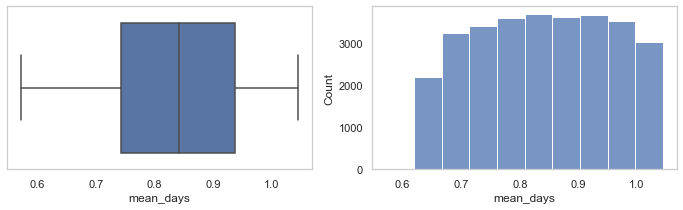

In [69]:
fig, axs = plt.subplots(figsize=(12, 3))

plt.subplot(1, 2, 1)
sns.boxplot(x='mean_days', data=client_df)

plt.subplot(1, 2, 2)
sns.histplot(x='mean_days', data=client_df, bins=10);

In [70]:
group_codes = [1, 11, 5, 14, 80, 24]
tmp[tmp['small_group_code'].isin(group_codes)]

,mean,count,max,min,sum,small_group,small_group_code
1,41.603924,8118439.0,22447.980469,0.002,337758912.0,Сетевые супермаркеты и продуктовые магазины,1
5,803.839966,81168.0,128202.882812,0.043,65246080.0,Авиабилеты,5
11,21.330620,3198759.0,11515.068359,0.001,68231512.0,Фастфуд и кафе,11
14,800.391663,28890.0,284318.687500,0.014,23123314.0,Автодилеры и автосервис,14
24,197.390015,462684.0,291837.218750,0.002,91329200.0,Одежда,24
80,390.925049,45380.0,319685.687500,0.043,17740178.0,Аксессуары (драгоценности и часы),80


one transaction a day...

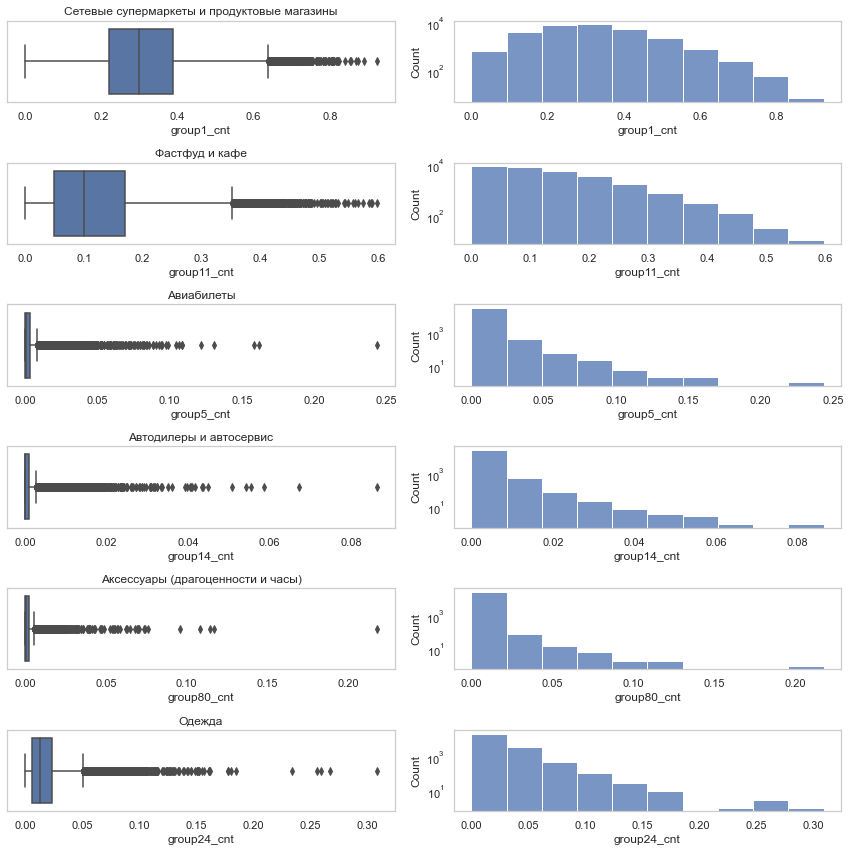

In [71]:
fig, axs = plt.subplots(figsize=(12, 12))

for i, g in enumerate(group_codes):
    plt.subplot(len(group_codes), 2, 2*i+1)
    gt = code2group[g]
    plt.title(gt)
    sns.boxplot(x=f'group{g}_cnt', data=client_df)
    plt.subplot(len(group_codes), 2, 2*i+2)
    sns.histplot(x=f'group{g}_cnt', data=client_df, bins=10);
    plt.yscale('log')
fig.tight_layout()

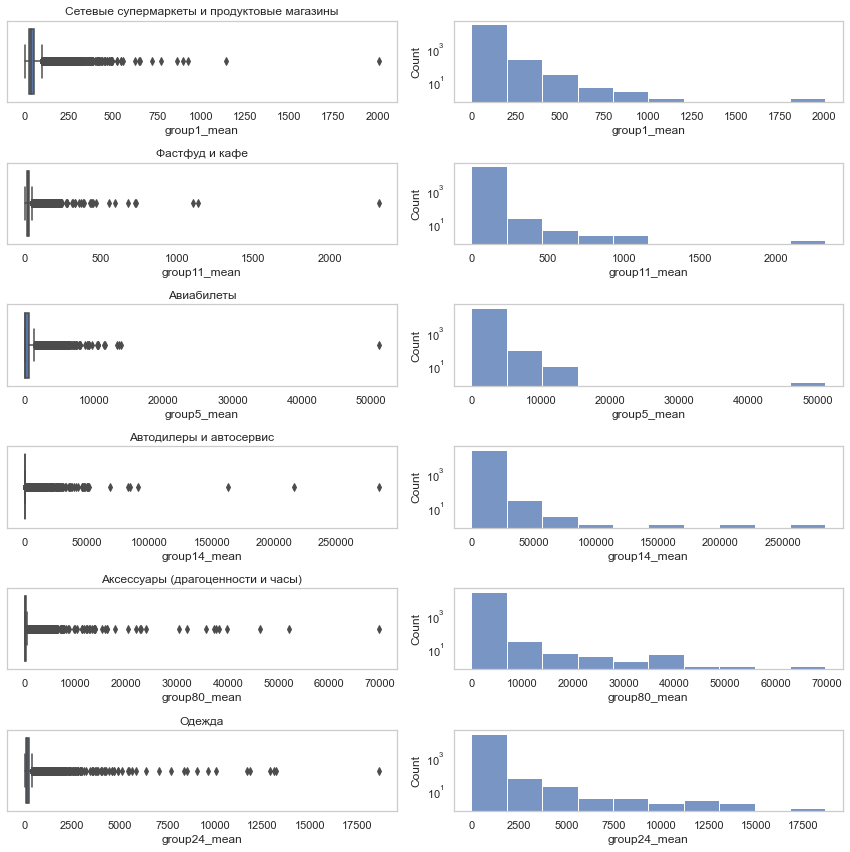

In [72]:
fig, axs = plt.subplots(figsize=(12, 12))

for i, g in enumerate(group_codes):
    plt.subplot(len(group_codes), 2, 2*i+1)
    gt = code2group[g]
    plt.title(gt)
    sns.boxplot(x=f'group{g}_mean', data=client_df)
    plt.subplot(len(group_codes), 2, 2*i+2)
    sns.histplot(x=f'group{g}_mean', data=client_df, bins=10);
    plt.yscale('log')
fig.tight_layout()

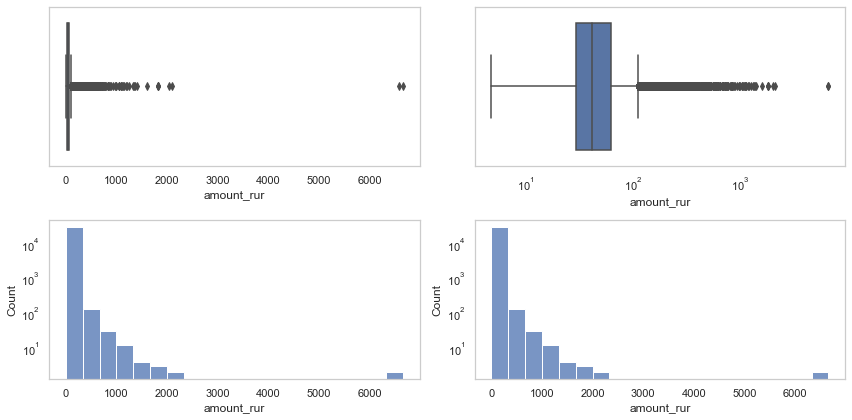

In [73]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.boxplot(x='amount_rur', data=client_df)
plt.subplot(2, 2, 2)
sns.boxplot(x='amount_rur', data=client_df)
plt.xscale('log')

plt.subplot(2, 2, 3)
sns.histplot(x='amount_rur', data=client_df, bins=20);
plt.yscale('log')
plt.subplot(2, 2, 4)
sns.histplot(x='amount_rur', data=client_df, bins=20);
plt.yscale('log')

fig.tight_layout()

cluster clients based on their groups

total spending in each group

In [79]:
tmp = df.groupby(['client_id', 'small_group'])['amount_rur'].agg(['sum']).reset_index()
tmp = tmp.pivot(index='client_id', columns='small_group', values=['sum'])
#tmp = tmp.fillna(0)

In [80]:
tmp.columns = [f'group{int(c2)}_{c1}' for c1, c2 in tmp.columns]

In [82]:
tmp = tmp.fillna(0)

In [83]:
X = tmp.copy()

### UMAP, age bins, group sum

In [86]:
from umap import UMAP

In [87]:
umap = UMAP(
    n_components=2,
    init='random',
    min_dist=0.5,
    random_state=228)

In [88]:
# takes 20 seconds on my pc
X_umap = umap.fit_transform(X)

In [89]:
df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
df_to_plot['bins'] = client_df['bins'].astype(str)

Text(0.5, 1.0, 'UMAP embedding of the clients')

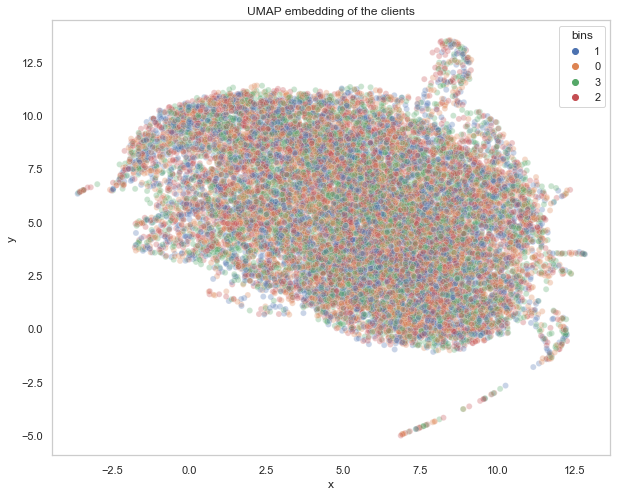

In [90]:
fig, axs = plt.subplots(figsize=(10, 8))

sns.scatterplot(
    x='x', y='y', hue='bins',
    data=df_to_plot,
    alpha=0.3)


plt.title("UMAP embedding of the clients")

  0%|          | 0/4 [00:00<?, ?it/s]

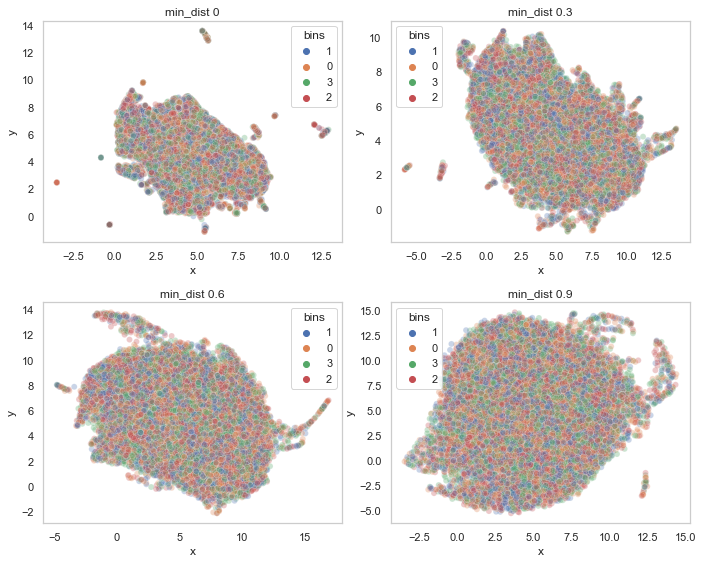

In [94]:
fig, axs = plt.subplots(figsize=(10, 8))

dists = [0, 0.3, 0.6, 0.9]
#dists = [0, 0.9]

for i, min_dist in tqdm(list(enumerate(dists))):
    plt.subplot((len(dists)+1)//2, 2, i+1)
    umap = UMAP(
        n_components=2,
        init='random',
        min_dist=min_dist,
        random_state=228)
    X_umap = umap.fit_transform(X)
    
    df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
    df_to_plot['bins'] = client_df['bins'].astype(str)
    sns.scatterplot(
        x='x', y='y', hue='bins',
        data=df_to_plot,
        alpha=0.3)

    plt.title(f"min_dist {min_dist}")
fig.tight_layout()

  0%|          | 0/3 [00:00<?, ?it/s]

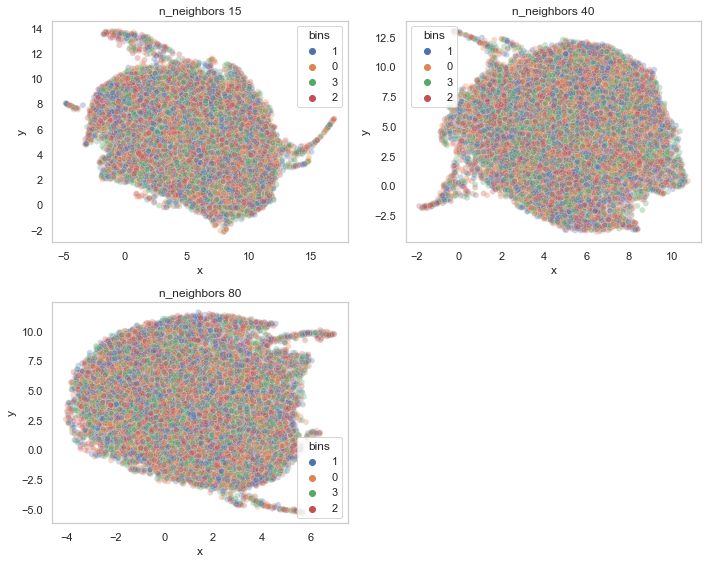

In [95]:
fig, axs = plt.subplots(figsize=(10, 8))

neighbors = [15, 40, 80]


for i, n_neighbors in tqdm(list(enumerate(neighbors))):
    plt.subplot((len(neighbors)+1)//2, 2, i+1)
    umap = UMAP(
        n_components=2,
        init='random',
        min_dist=0.6,
        n_neighbors=n_neighbors,
        random_state=228)
    X_umap = umap.fit_transform(X)
    
    df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
    df_to_plot['bins'] = client_df['bins'].astype(str)
    sns.scatterplot(
        x='x', y='y', hue='bins',
        data=df_to_plot,
        alpha=0.3)

    plt.title(f"n_neighbors {n_neighbors}")
fig.tight_layout()

### UMAP, k means group sum

In [96]:
from sklearn.cluster import KMeans

In [88]:
# 1 min 36 sec
inertia = []
ks = range(2, 10, 3)
for k in ks:
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

2
5
8


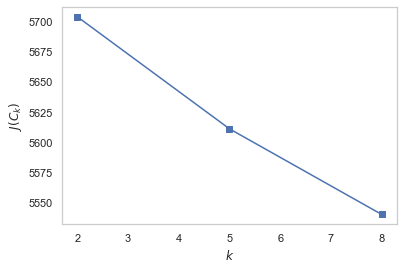

In [89]:
plt.plot(ks, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

4 clusters

In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
X_scaled = StandardScåaler().fit_transform(X)

In [108]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X_scaled)

In [109]:
pd.Series(kmeans.labels_).value_counts()

2    29223
0      769
3        6
1        1
4        1
dtype: int64

In [92]:
# take umap
df_to_plot = pd.DataFrame(X_umap, columns=['x', 'y'])
df_to_plot['bins'] = client_df['bins'].astype(str)
df_to_plot['k-label'] = kmeans.labels_
df_to_plot['k-label'] = df_to_plot['k-label'].astype(str)

In [93]:
df_to_plot_not_scaled = df_to_plot.copy()

In [ ]:
fig, axs = plt.subplots(figsize=(16, 8))

plt.subplot(1, 2, 1)

sns.scatterplot(
    x='x', y='y', hue='k-label',
    data=df_to_plot,
    alpha=0.2)
plt.title('UMAP representations of K-Means clusters')

plt.subplot(1, 2, 2)

plt.title('UMAP representations of age groups')

sns.scatterplot(
    x='x', y='y', hue='bins',
    data=df_to_plot_umap,
    alpha=0.2)

fig.tight_layout()